# Introduction to Machine Learning (CSCI-UA.473)

## Lab 3: Regularization & Logistic Regression

In [1]:
# Let's import some packages we'll need.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import pandas as pd
import autograd.numpy as np
from autograd import grad

matplotlib.__version__

'3.5.0'

In [2]:
# Load data:
sata = np.genfromtxt('extendedHousingSata.csv', delimiter=',')
print(sata.shape)

(2000, 7)


## This new sata set has two additional features. We inspect the correlations between the features to see if we find anything unusual.

In [3]:
# Check correlations between different features of our data
# check collinearity
np.corrcoef(sata[:,2], sata[:,3])

array([[ 1.        , -0.03516956],
       [-0.03516956,  1.        ]])

In [4]:
# Next we sample datapoints to see how variable our betas are!
nSample = 200 # Sub-Sampling points
nPop = len(sata)  # The full population
nReps = 1000 # How many times are we doing this?
# Declare a structure to store our betas
betasOLS = np.empty([np.size(sata,axis=1),nReps])*np.NaN

In [5]:
for ii in range(nReps): 
    # Sample nSample number of indexes from our data randomly
    sampleIndices = np.random.randint(0,nPop-1,nSample) 
    # shape is (200,)
    trainSamples = sata[sampleIndices,:]
    # House price, our "label" is the fourth feature
    y = trainSamples[:,4]
    # Use remaining features for training
    x = np.delete(trainSamples, 4, 1)
    # The data is varying in scale and variance, subtracting the mean and dividing by the standard deviation is 
    # a common technique use to "normalize" the data
    x_norm = (x - np.mean(x, axis=0))/np.std(x, axis=0)
    y_norm = (y - np.mean(y, axis=0))/np.std(y, axis=0)
    # Run OLS and store betas:
    ols = LinearRegression().fit(x_norm,y_norm)
    betasOLS[:,ii] = np.concatenate((np.array([ols.intercept_]), ols.coef_),axis=0)
    

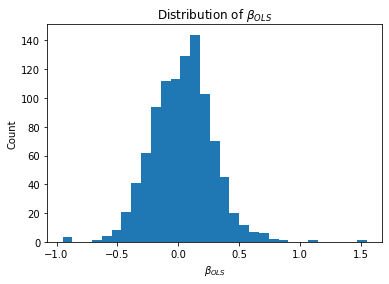

In [6]:
nBins = 31 # odd number
plt.xlabel(r'$\beta_{OLS}$')
plt.ylabel('Count')
plt.title(r'Distribution of $\beta_{OLS}$')
plt.hist(betasOLS[5,:],nBins);

In [7]:
# Lets pick a value for lambda randomly
# more lambda means more shrinkage, affect regularization
lambd = 10
betasRidge = np.empty([np.size(sata,axis=1),nReps])*np.NaN
for ii in range(nReps):
    # We repreat our training process, this time using the Ridge model instead of the vanilla LinearRegression
    sampleIndices = np.random.randint(0,nPop-1,nSample) 
    trainSamples = sata[sampleIndices,:]
    y = trainSamples[:,4]
    x = np.delete(trainSamples, 4, 1)
    # axis = 0, 沿纵轴操作，axis = 1， 沿横轴操作，axis = i，沿第i个下标变化操作
    x_norm = (x - np.mean(x, axis=0))/np.std(x, axis=0)
    y_norm = (y - np.mean(y, axis=0))/np.std(y, axis=0)
    # Run Ridge and store betas:
    ridge = Ridge(alpha=lambd).fit(x_norm,y_norm)
    betasRidge[:,ii] = np.concatenate((np.array([ridge.intercept_]), ridge.coef_),axis=0)

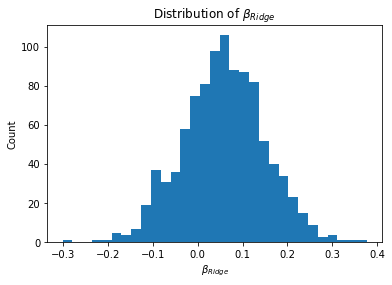

In [8]:
nBins = 31
plt.xlabel(r'$\beta_{Ridge}$')
plt.ylabel('Count')
plt.title(r'Distribution of $\beta_{Ridge}$')
plt.hist(betasRidge[5,:],nBins);

In [9]:
lambd = 10
betasOLS = np.empty([np.size(sata,axis=1),nReps])*np.NaN
betasRidge = np.empty([np.size(sata,axis=1),nReps])*np.NaN
for ii in range(nReps):
    # We repreat our training process, this time using the Ridge model instead of the vanilla LinearRegression
    sampleIndices = np.random.randint(0,nPop-1,nSample) 
    trainSamples = sata[sampleIndices,:]
    y = trainSamples[:,4]
    x = np.delete(trainSamples, 4, 1)
    x_norm = (x - np.mean(x, axis=0))/np.std(x, axis=0)
    y_norm = (y - np.mean(y, axis=0))/np.std(y, axis=0)
    # Run OLS and store betas:
    ols = LinearRegression().fit(x_norm,y_norm)
    betasOLS[:,ii] = np.concatenate((np.array([ols.intercept_]), ols.coef_),axis=0)
    # Run Ridge and store betas:
    ridge = Ridge(alpha=lambd).fit(x_norm,y_norm)
    betasRidge[:,ii] = np.concatenate((np.array([ridge.intercept_]), ridge.coef_),axis=0)

Text(0.5, 1.0, 'Spread of $\\beta_{OLS}$ and $\\beta_{Ridge}$')

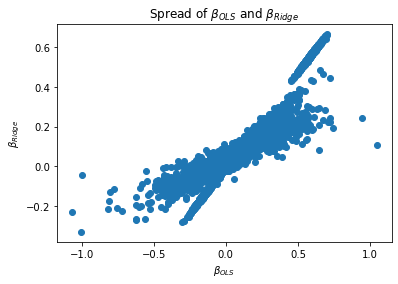

In [10]:
## Add a scatter plot for values of betas before and after regularization 
plt.scatter(betasOLS, betasRidge)
plt.xlabel(r'$\beta_{OLS}$')
plt.ylabel(r'$\beta_{Ridge}$')
plt.title(r'Spread of $\beta_{OLS}$ and $\beta_{Ridge}$')

## But how to we choose a value for $\lambda$ ?

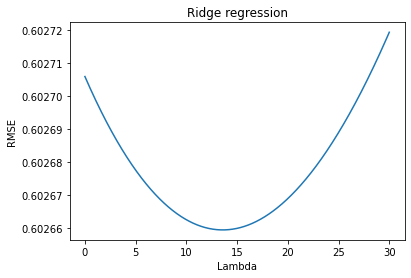

Optimal lambda: 13.59


In [11]:
# Add hyperparameter tuning to the above example
lambdas = np.linspace(0,30,1001)
cont = np.empty([len(lambdas),2])*np.NaN # [lambda error]
y = sata[:,4]
x = np.delete(sata, 4, 1)
# Again we normalize our data
x_norm = (x - np.mean(x, axis=0))/np.std(x, axis=0)
y_norm = (y - np.mean(y, axis=0))/np.std(y, axis=0)
xTrain, xTest, yTrain, yTest = model_selection.train_test_split(x_norm, y_norm.reshape(-1,1), test_size=0.2, random_state=0)
for ii in range(len(lambdas)):
    ridgeModel = Ridge(alpha=lambdas[ii]).fit(xTrain, yTrain)
    cont[ii,0] = lambdas[ii]
    error = metrics.mean_squared_error(yTest,ridgeModel.predict(xTest))
    cont[ii,1] = error

plt.plot(cont[:,0],cont[:,1])
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.title('Ridge regression')
plt.show()
print('Optimal lambda:',lambdas[np.argmax(cont[:,1]==np.min(cont[:,1]))])

## That was Ridge regression, but we can use Lasso as well!

In [12]:
# We repeat our initial experiment again
nSample = 200 # Sub-Sampling points
nPop = len(sata)  # The full population
nReps = 1000 # How many times are we doing this?
# Declare a structure to store our betas
betasOLS = np.empty([np.size(sata,axis=1),nReps])*np.NaN

In [13]:
# This is OLS repeated, to compare
for ii in range(nReps): 
    # Sample nSample number of indexes from our data randomly
    sampleIndices = np.random.randint(0,nPop-1,nSample) 
    trainSamples = sata[sampleIndices,:]
    # House price, our "label" is the fourth feature
    y = trainSamples[:,4]
    # Use remaining features for training
    x = np.delete(trainSamples, 4, 1)
    # The data is varying in scale and variance, subtracting the mean and dividing by the standard deviation is 
    # a common technique use to "normalize" the data
    x_norm = (x - np.mean(x, axis=0))/np.std(x, axis=0)
    y_norm = (y - np.mean(y, axis=0))/np.std(y, axis=0)
    # Run OLS and store betas:
    ols = LinearRegression().fit(x_norm,y_norm)
    betasOLS[:,ii] = np.concatenate((np.array([ols.intercept_]), ols.coef_),axis=0)
    

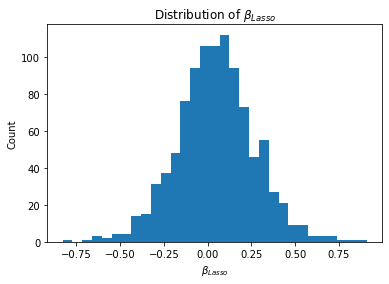

In [14]:
nBins = 31
plt.xlabel(r'$\beta_{Lasso}$')
plt.ylabel('Count')
plt.title(r'Distribution of $\beta_{Lasso}$')
plt.hist(betasOLS[6,:],nBins);

In [15]:
# Lets pick a value for lambda randomly
lambd = 1e-2
betasLasso = np.empty([np.size(sata,axis=1),nReps])*np.NaN
for ii in range(nReps):
    # We repreat our training process, this time using the Ridge model instead of the vanilla LinearRegression
    sampleIndices = np.random.randint(0,nPop-1,nSample) 
    trainSamples = sata[sampleIndices,:]
    y = trainSamples[:,4]
    x = np.delete(trainSamples, 4, 1)
    x_norm = (x - np.mean(x, axis=0))/np.std(x, axis=0)
    y_norm = (y - np.mean(y, axis=0))/np.std(y, axis=0)
    # Run Ridge and store betas:
    lasso = Lasso(alpha=lambd).fit(x_norm,y_norm)
    betasLasso[:,ii] = np.concatenate((np.array([lasso.intercept_]), lasso.coef_),axis=0)

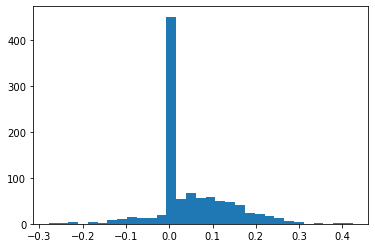

In [16]:
nBins = 31
plt.hist(betasLasso[6,:],nBins);

In [17]:
lambd = 1e-2
betasOLS = np.empty([np.size(sata,axis=1),nReps])*np.NaN
betasLasso = np.empty([np.size(sata,axis=1),nReps])*np.NaN
for ii in range(nReps):
    # We repreat our training process, this time using the Ridge model instead of the vanilla LinearRegression
    sampleIndices = np.random.randint(0,nPop-1,nSample) 
    trainSamples = sata[sampleIndices,:]
    y = trainSamples[:,4]
    x = np.delete(trainSamples, 4, 1)
    x_norm = (x - np.mean(x, axis=0))/np.std(x, axis=0)
    y_norm = (y - np.mean(y, axis=0))/np.std(y, axis=0)
    # Run OLS and store betas:
    ols = LinearRegression().fit(x_norm,y_norm)
    betasOLS[:,ii] = np.concatenate((np.array([ols.intercept_]), ols.coef_),axis=0)
    # Run Ridge and store betas:
    lasso = Lasso(alpha=lambd).fit(x_norm,y_norm)
    betasLasso[:,ii] = np.concatenate((np.array([lasso.intercept_]), lasso.coef_),axis=0)

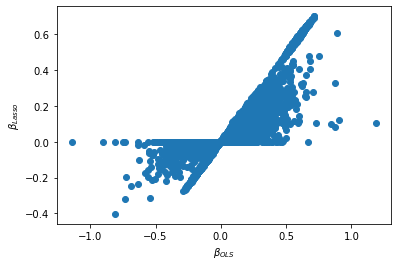

In [18]:
## Add a scatter plot for values of betas before and after regularization
plt.scatter(betasOLS, betasLasso)
plt.xlabel(r'$\beta_{OLS}$')
plt.ylabel(r'$\beta_{Lasso}$');

# Using Autograd

Autograd is a package for automatic differentiation.  ``autograd.numpy`` is a wrapper for Numpy which contains the same basic operations.  In most machine learning algorithms we need the gradient of a certain loss function to fit our model to the given data.  Autograd computes this gradient automatically for us so that we may use methods such as gradient descent.  A popular function used in logistic regression as well as neural nets is the sigmoid function

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

The derivative is given by

$$
\sigma'(x) = \frac{e^{-x}}{(1 + e^{-x})^2} = \sigma(x) (1 - \sigma(x))
$$

We could either compute this derivative by hand and then hard code it explicitly, or we could just call autograd.

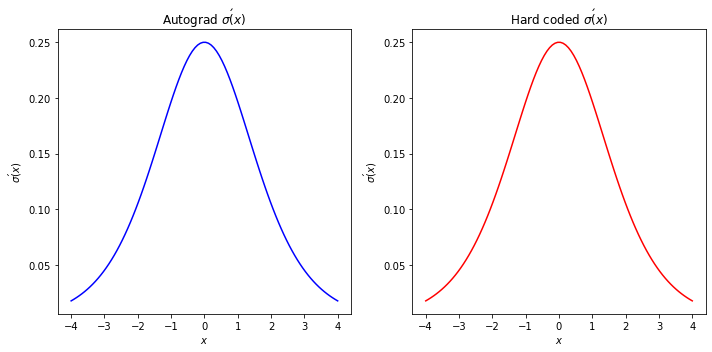

In [19]:
# Define the sigmoid function.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Hard code the gradient of the sigmoid function.
def grad_sigmoid(x):
    y = sigmoid(x)
    return y * (1 - y)

# Evaluate the gradient using autograd.
grad_sig = grad(sigmoid)

# Plot the two gradients side by side.
x = np.linspace(-4, 4, 100)


# We'll have 2 plots side by side.
fig = plt.figure(3, figsize = (10, 5))

# First plot the autograd derivative.
ax1 = plt.subplot(121) # create a figure with 1 row and 2 columns and get the axis 
y1 = np.asarray([grad_sig(x[i]) for i in range(len(x))])
ax1.plot(x, y1, 'b')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\sigma\'(x)$')
ax1.set_title(r'Autograd $\sigma\'(x)$')

# Second plot the hard-coded derivative.
ax2 = plt.subplot(122)
y2 = grad_sigmoid(x)
ax2.plot(x, y2, 'r')
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$\sigma\'(x)$')
ax2.set_title(r'Hard coded $\sigma\'(x)$')

plt.tight_layout();

## Part 1: Logistic Regression using Synthetic Data and Autograd

We will play around with the logistic regression model implemented from scratch and trained using autograd on synthetic data. 

### Generate the data and plot it


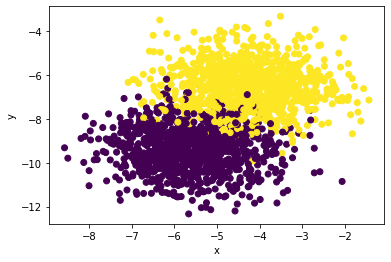

In [22]:
# For the plots in the remainder of this notebook we will use a widget to get interactive and better looking plots! 
# follow these instructions to set up matplotlib widget for Jupyter Lab
# https://github.com/matplotlib/jupyter-matplotlib#installation
# Specifically you will need to install the widget using : conda install -c conda-forge ipympl
# To enable the widget run the following two commands :
# jupyter nbextension install --py --symlink --sys-prefix --overwrite ipympl
#jupyter nbextension enable --py --sys-prefix ipympl

import numpy
from tqdm import tqdm
from sklearn.datasets import make_blobs

# random_seed = numpy.random.randint(0,100)
random_seed = 65

x, y = make_blobs(n_samples=2000, centers=2, n_features=2, random_state=random_seed)

fig = plt.figure()
plt.scatter(x[:,0], x[:,1], c=y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we have a set of data points $\{(x_{1}, y_{1}), (x_{2}, y_{2}), ... , (x_{n}, y_{n})\}$, where $x_{i} \in R^{d}$ are the feature vectors and $y_{i} \in \{0, 1\}$ are the class labels.

### Split the data into training set and validation set
We consider the first 1500 points as our training set and the remaining 500 as our validation set. 
<b>Is this correct?</b> 

In [23]:
x_train, y_train = x[:1500], y[:1500]
x_val, y_val = x[1500:], y[1500:]

# sanity check
assert len(x_train) == len(y_train) == 1500
assert len(x_val) == len(y_val) == 500

# should we check anything else?

### Build the model
Logistic regression model outputs the posterior probability of the class label to be equal to 1. 
$$p_{+} = p(y = 1|x) = \frac{1}{1 + e^{-w \cdot x + b}},$$ 
where $w \in R^{d}$ and $b \in R$.

Sigmoid function is used to convert the output of the linear operation into probabilities. 

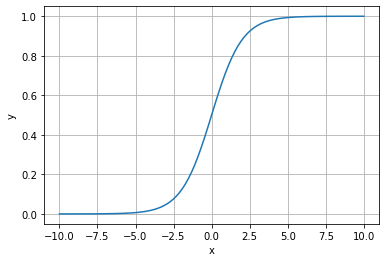

In [24]:
def plot_function(f):
    x = numpy.linspace(-10,10,100)
    y = f(x)
    
    return plt.plot(x,y)

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plot_function(sigmoid)
plt.grid(True)
plt.show()

Now lets build the logistic regression model. 

In [25]:
def logistic_unit(x, w, b):
    """This function computes logistic unit as defined $p_{+}$ above
    :param x: input x with n_dim features
    :param w: weght vector
    :param b: bias vector
    """
    
    # operator @ means matrix multiplication in python <3.5
    # https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.matmul.html#numpy.matmul
    
    pre_sigmoid = x @ w + b
    logit = sigmoid(pre_sigmoid)
    
    return logit

### Loss Function
The loss function of the logistic regression is given by: 

$$\mathcal{L}(x,y) = - ( y \cdot \log(p_{+}) + (1 - y) \cdot \log(1 - p_{+}) )$$

Note that $p_{+}$ depends on $x$ and $w$.

In [26]:
NEAR_ZERO = 1e-12

def loss_function(x, y, w, b):
    """This function computes the loss (distance)
    :param logits: output from logistic unit
    :param labels: target label
    """
    logits = logistic_unit(x,w,b)
    labels = y
    
    loss = -(labels * numpy.log(logits + NEAR_ZERO) + (1 - labels) * numpy.log(1 - logits + NEAR_ZERO))
    
    return loss

Now lets do a sanity check and compute the loss between the target and prediction given a randomly initialized model.

In [27]:
# sanity check
n_dim=2
w0 = 0.01 * numpy.random.randn(n_dim)
b0 = 0.0

inp = x_train[0]
label = y_train[0]

out = logistic_unit(inp, w0, b0)
assert (out < 1) and (out > 0)  # why?

loss = loss_function(inp, label, w0, b0)
print(loss)

0.7647940161063324


### Use Autograd for computing the derivatives and train the model
As discussed in the previous lab, with Autograd we do not need to compute the gradients by hand and code it. This is very handy when we have huge DAG (Directed Acyclic Graph) computations.
There is an active line of research in automatic differentiation, curious students are adviced to read this:
http://jmlr.org/papers/volume18/17-468/17-468.pdf

In [28]:
# Install autograd:
#!conda install -c conda-forge autograd

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import elementwise_grad

import scipy.optimize

In [29]:
loss_grad_w = elementwise_grad(loss_function, 2) # partial derivative wrt the weights w (3rd input)
loss_grad_b = elementwise_grad(loss_function, 3) # partial derivative wrt the bias b (4th input)

In [30]:
n_iter = 10000
eta = .0001   # Learning rate
w = numpy.copy(w0)
b = numpy.copy(b0)

loss_log = []

for ni in tqdm(range(n_iter)):
    dw = loss_grad_w(x_train, y_train, w, b)
    db = loss_grad_b(x_train, y_train, w, b)
    w -= eta * dw
    b -= eta * db
    
    loss = numpy.mean(loss_function(x_train, y_train, w, b))
    loss_log.append(loss)

100%|██████████| 10000/10000 [00:06<00:00, 1525.97it/s]


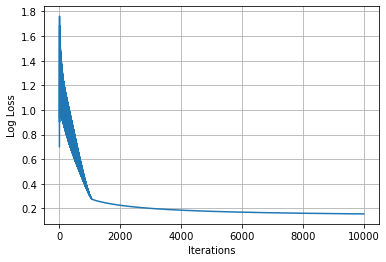

In [31]:
# lets plot the running element-wise loss value
plt.figure()
plt.plot(loss_log)
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.grid(True)
plt.show()

### Plot the data: the actual data and the model (hyperplane)
We start with first defining some visualization routines and then we do the actual plotting. 

Some visualization routines: 

In [32]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    for x_, y_ in zip(x, y):
        if y_ is None:
            plt.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plt.grid('on')
    
def vis_hyperplane(w, b, typ='k--'):

    lim0 = plt.gca().get_xlim()
    lim1 = plt.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + b)/w[1]
    intercept1 = -(w[0] * m1 + b)/w[1]
    
    plt1, = plt.plot([m0, m1], [intercept0, intercept1], typ)

    plt.gca().set_xlim(lim0)
    plt.gca().set_ylim(lim1)
        
    return plt1

def vis_decision_boundary_contour(w, b, typ='k--'):
    
    lim0 = plt.gca().get_xlim()
    lim1 = plt.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    x_tra_ = numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1)
    
    pred = logistic_unit(x_tra_, w, b)
    plt1 = plt.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)
    
    plt.colorbar(plt1)
    
    plt.gca().set_xlim(lim0)
    plt.gca().set_ylim(lim1)
        
    return plt1

Now plot the data. 

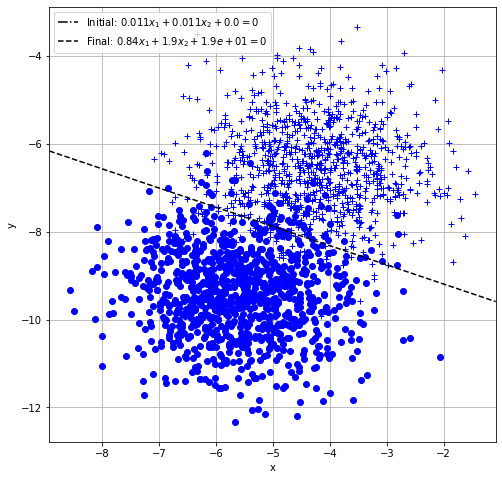

In [33]:
plt.figure(figsize=(8,8))

vis_data(x, y, c='b')

plt0 = vis_hyperplane(w0, b0, 'k-.')
plt1 = vis_hyperplane(w, b, 'k--')
plt.legend([plt0, plt1], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)+[b0]),
        'Final: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w)+[b])],
           loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()